**Traffic Prediction using graph Neural Networks**

In [ ]:
##importing necessary liabrararies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import torch
torch.Tensor(1)

import torch
import torch.nn.functional as F
print(torch.__version__)
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric-temporal
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
# GPU support
DEVICE = torch.device('cuda') # cuda
print(DEVICE)
shuffle=True
batch_size = 32

1.11.0+cu113
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 13.4 MB/s 
     |████████████████████████████████| 3.5 MB 49.5 MB/s 
     |████████████████████████████████| 407 kB 14.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=007e88393a5b705574f1c77671b28731a0a79ce012474672e1d18ccd7a8cde06
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 48 kB 3.9 MB/s 
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.52.0-py3-none-any.whl size=86194 sha256=99186ca73fb4bc32e07b24e99ca2d9fb5724b72a167b63c9cc8d08283fbdef67
  Stored in directory: /root/.cache/pip/wheels/eb/f1/e5/dd02c6d1e5f00f907f5e4894c60c5a21b774db1ed7464d0c23
Successfully built torch-geometric-temporal
cuda


#PEMS-08:

170 detectors
July to Augest in 2016
3 features: flow, occupy, speed.

In [ ]:
#import our data (PEMS08)

url_edge_info = "https://raw.githubusercontent.com/wanhuaiyu/ASTGCN/master/data/PEMS08/distance.csv"
url_node_features = "https://github.com/wanhuaiyu/ASTGCN/blob/master/data/PEMS08/pems08.npz"
edge_info = pd.read_csv(url_edge_info)
node_features = np.load("/content/drive/MyDrive/traffic pred.by gnn/data.npy")

**edge_info**: This csv  file contains data of **distance between two nodes** and by using this information we can construct an **adjecency matrix** and with the help of these adjecency matrix we can **plot the graph.** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
edge_info 

,from,to,cost
0,9,153,310.6
1,153,62,330.9
2,62,111,332.9
3,111,11,324.2
4,11,28,336.0
...,...,...,...
290,154,5,166.3
291,78,107,143.9
292,107,46,236.3
293,118,145,250.6


In [ ]:
node_features ##this data fie contain information about features of each nodes present in our data in the shape(17856,170,3):(number of data points,number of sensors,number of features)

array([[[1.330e+02, 6.030e-02, 6.580e+01],
        [2.100e+02, 5.890e-02, 6.960e+01],
        [1.240e+02, 3.580e-02, 6.580e+01],
        ...,
        [7.400e+01, 2.131e-01, 6.530e+01],
        [9.400e+01, 2.260e-02, 6.800e+01],
        [6.000e+00, 3.100e-03, 6.500e+01]],

       [[1.140e+02, 5.320e-02, 6.690e+01],
        [1.850e+02, 5.500e-02, 6.850e+01],
        [1.190e+02, 3.390e-02, 6.500e+01],
        ...,
        [7.300e+01, 1.469e-01, 3.720e+01],
        [8.400e+01, 1.890e-02, 6.870e+01],
        [4.000e+00, 1.800e-03, 6.500e+01]],

       [[1.400e+02, 6.220e-02, 6.680e+01],
        [1.710e+02, 4.660e-02, 6.990e+01],
        [1.070e+02, 3.360e-02, 6.380e+01],
        ...,
        [7.000e+01, 5.860e-02, 3.400e+01],
        [8.200e+01, 2.200e-02, 6.700e+01],
        [4.000e+00, 2.100e-03, 6.490e+01]],

       ...,

       [[1.200e+02, 5.810e-02, 6.330e+01],
        [1.760e+02, 5.290e-02, 6.680e+01],
        [1.190e+02, 5.180e-02, 5.610e+01],
        ...,
        [4.700e+01, 1.551e

In [ ]:
A = np.zeros((170, 170),dtype=np.float32) ##initiaaly creating (170*170) matrix with all values zero
#assigning value 1 to the matrix elements which having connection between them(which gives us adjecency matrix)
distanceA = np.zeros((170, 170), dtype=np.float32) 
for index, row in edge_info.iterrows():
    i = int(row["from"])
    j = int(row['to'])
    distance = row['cost']
    A[i, j] = 1
    distanceA[i][j] = distance

In [ ]:
node_features.shape

(17856, 170, 3)

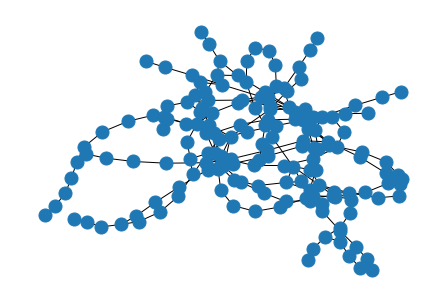

In [ ]:
#ploting graph o the basis of adjecency matrix created in previous step.
import matplotlib.pyplot as plt
import networkx as nx

def show_graph_with_labels(A):
    rows, cols = np.where(A == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=170)
    plt.show()

show_graph_with_labels(A)


In [ ]:
from torch_geometric_temporal import StaticGraphTemporalSignal
#import StaticGraphTemporalSignal

class METRLADatasetLoader(object):
    def _read_web_data(self):
        url = "https://graphmining.ai/temporal_datasets/METR-LA.zip"
        url_edge_info = "https://raw.githubusercontent.com/wanhuaiyu/ASTGCN/master/data/PEMS08/distance.csv"
        url_node_features = "https://github.com/wanhuaiyu/ASTGCN/blob/master/data/PEMS08/pems08.npz"
        edge_info = pd.read_csv(url_edge_info)
        X = np.load("data.npy").transpose(1, 2, 0)
        A = np.zeros((170, 170),dtype=np.float32)
        distanceA = np.zeros((170, 170), dtype=np.float32)
        for index, row in edge_info.iterrows():
            i = int(row["from"])
            j = int(row['to'])
            distance = row['cost']
            A[i, j] = 1
            distanceA[i][j] = distance
        X = X.astype(np.float32)

        # Normalise as in DCRNN paper (via Z-Score Method)
        means = np.mean(X, axis=(0, 2))
        X = X - means.reshape(1, -1, 1)
        stds = np.std(X, axis=(0, 2))
        X = X / stds.reshape(1, -1, 1)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)

    def _get_edges_and_weights(self):
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self, num_timesteps_in: int = 12, num_timesteps_out: int = 12):
        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target
    def get_dataset(
        self, num_timesteps_in: int = 12, num_timesteps_out: int = 12
    ) -> StaticGraphTemporalSignal:
        """Returns data iterator for METR-LA dataset as an instance of the
        static graph temporal signal class.

        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
                forecasting dataset.
        """
        self._get_edges_and_weights()
        self._generate_task(num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )
        return dataset

In [ ]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(set(dataset)))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f90510977d0>
Number of samples / sequences:  34249


In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [ ]:
train_input = np.array(train_dataset.features)
train_target = np.array(train_dataset.targets)
train_input_tensor = torch.from_numpy(train_input)
train_target_tensor = torch.from_numpy(train_target)
train_dataset_new = torch.utils.data.TensorDataset(train_input_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [ ]:
test_input = np.array(test_dataset.features)
test_target = np.array(test_dataset.targets)
test_input_tensor = torch.from_numpy(test_input)
test_target_tensor = torch.from_numpy(test_target)
test_dataset_new = torch.utils.data.TensorDataset(test_input_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [ ]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [ ]:
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')  # If you notice here the Attention is a trainable parameter
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}]


In [ ]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index
    break;



# Training the model 
model.train()

for epoch in range(5):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.45059197962284087
0.4524831064045429
0.4526292758186658
0.45173954881727696
0.4537832381129265
0.45598050110042093
0.45553136499864716
0.4538990800641477
Epoch 0 train RMSE: 0.4538
0.45214205533266066
0.45130804270505903
0.44528337319691974
0.4507268238812685
0.45258408296108243
0.4503465539713701


In [ ]:
## Evaluation

#- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
#- The model always gets one hour and needs to predict the next hour

model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))


Test MSE: 0.5788


Data points:, (32,)


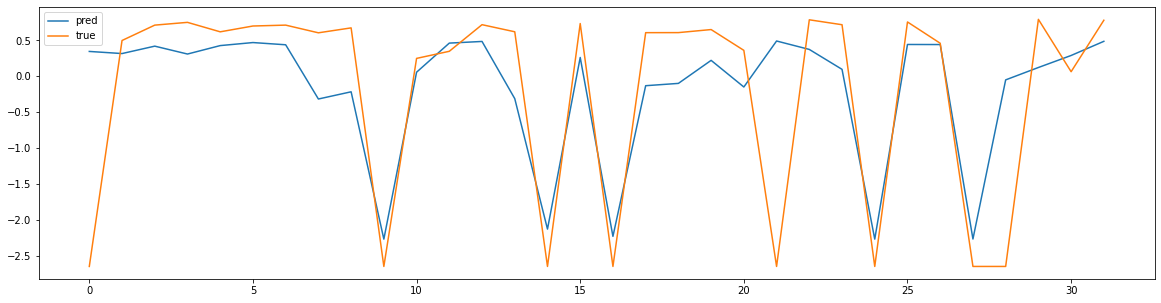

In [ ]:
### Visualization

#- The further away the point in time is, the worse the predictions get
#- Predictions shape: [num_data_points, num_sensors, num_timesteps]


sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")